## File Size

In [280]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Load data

In [281]:
def load_data(path: str):
    with open(path) as file:
        json_data = json.load(file)
    df = pd.DataFrame(json_data)

    if "_id" in df.columns:
        df = df.drop(columns="_id")
    if "file" in df.columns:
        df = df.drop(columns="file")
    if "unobfuscated_file" in df.columns:
      df = df.drop(columns="unobfuscated_file")

    return df

unobfuscated_unoptimized = load_data("./data/unoptimized/unobfuscated.json")
unobfuscated_optimized = load_data("./data/optimized/unobfuscated.json")

tigress_unoptimized = load_data("./data/unoptimized/tigress.json")
tigress_optimized = load_data("./data/optimized/tigress.json")

llvm_unoptimized = load_data("./data/unoptimized/llvm.json")
llvm_optimized = load_data("./data/optimized/llvm.json")

wasm_mutate_unoptimized = load_data("./data/unoptimized/wasm-mutate.json")
wasm_mutate_optimized = load_data("./data/optimized/wasm-mutate.json")

### Compute relative file size

In [282]:
def compute_relative_file_size(unobf_df, obf_df):
    obf_df['relative_file_size'] = None

    for index, row in obf_df.iterrows():
        name = row['name']
        file_size = row['file_size']
        unobf_file_size = unobf_df.loc[unobf_df['name'] == name, 'file_size'].iloc[0]
        relative_file_size = file_size / unobf_file_size

        obf_df.at[index, 'relative_file_size'] = relative_file_size
    return obf_df

tigress_unoptimized = compute_relative_file_size(unobfuscated_unoptimized, tigress_unoptimized)
tigress_optimized = compute_relative_file_size(unobfuscated_unoptimized, tigress_optimized)

llvm_unoptimized = compute_relative_file_size(unobfuscated_unoptimized, llvm_unoptimized)
llvm_optimized = compute_relative_file_size(unobfuscated_unoptimized, llvm_optimized)

wasm_mutate_unoptimized = compute_relative_file_size(unobfuscated_unoptimized, wasm_mutate_unoptimized)
wasm_mutate_optimized = compute_relative_file_size(unobfuscated_unoptimized, wasm_mutate_optimized)

In [283]:
def plot_relative_file_size_by_category(df, xlabel):
  plt.figure(figsize=(12, 6))
  sns.set(style="whitegrid")
  sns.barplot(data=df, x='transformation', y='relative_file_size', hue='category', errwidth=1.8, capsize=0.05, palette="tab20")

  plt.ylabel('Relative File Size')
  plt.xlabel(xlabel)

  # Rotate the x labels by 45 degrees
  plt.xticks(rotation=45)

  # Capitalize the first letter of the entries in the legend
  legend = plt.legend(title='Category', loc='best')
  for text in legend.get_texts():
      text.set_text(text.get_text().capitalize())

  plt.show()

In [284]:
def plot_relative_file_size_by_mining_variant(df, legend_title, centered_legend=False):
  names_to_include = ['cn-0', 'cn-1', 'cn-2', 'cn-r']
  df = pd.concat([df.query(f"name == '{name}'") for name in names_to_include])

  plt.figure(figsize=(12, 6))
  sns.set(style="whitegrid")
  sns.barplot(data=df, x='name', y='relative_file_size', hue='transformation', errwidth=1.8, capsize=0.05, palette="tab20")

  plt.ylabel('Relative File Size')
  plt.xlabel('Cryptonight Variant')

  # Set custom xtick labels
  plt.xticks(range(len(names_to_include)))

  if centered_legend: 
    ax = plt.gca()
    ax.set_ylim(0, ax.get_ylim()[1] * 1.2)
    plt.legend(title=legend_title, loc='upper center', ncol=4)
  else: 
    plt.legend(title=legend_title, loc='best', ncol=4)


  plt.show()


### Tigress

#### Unoptimized

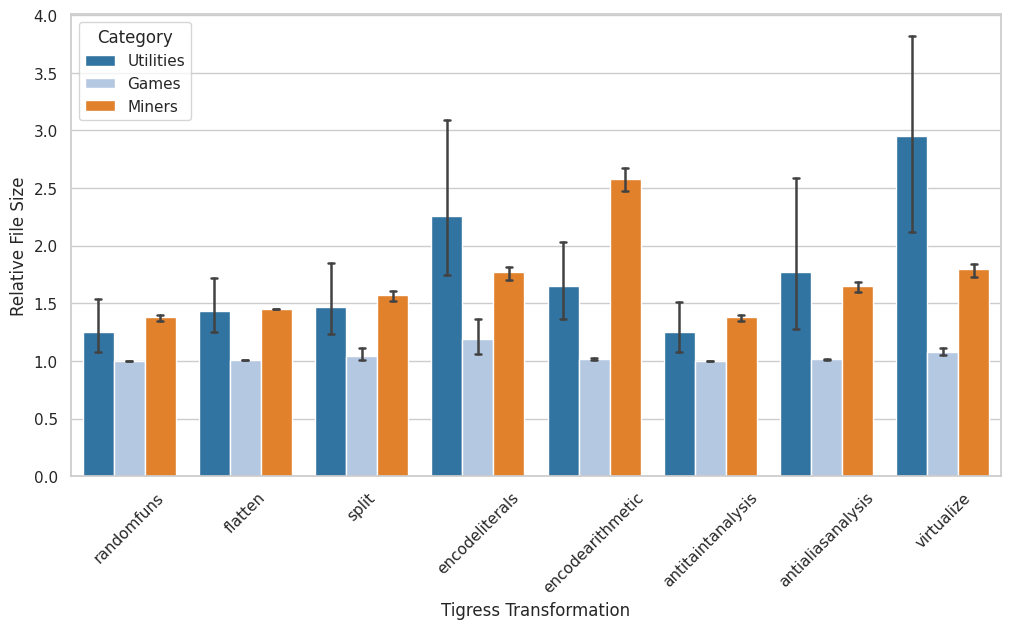

In [285]:
plot_relative_file_size_by_category(tigress_unoptimized, xlabel='Tigress Transformation')

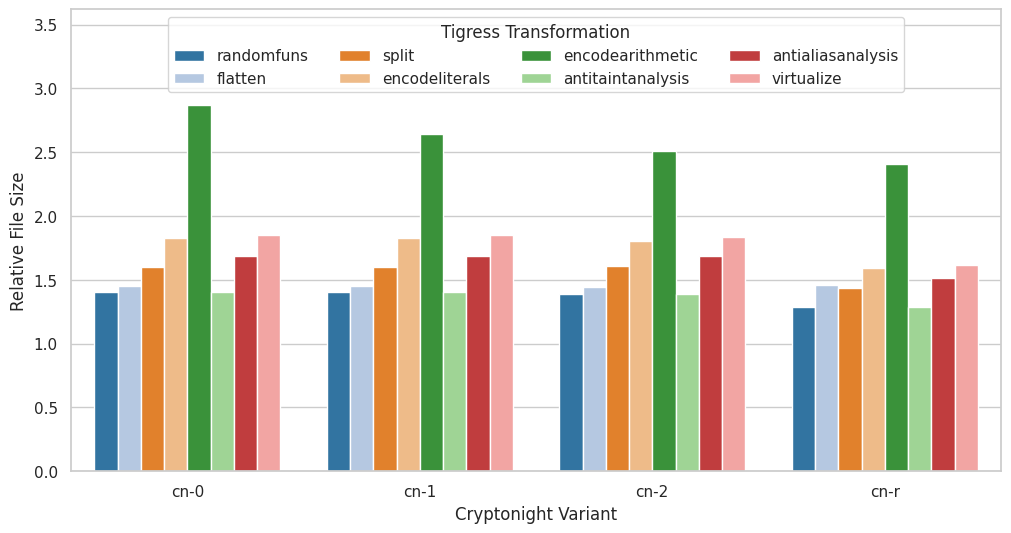

In [286]:
plot_relative_file_size_by_mining_variant(tigress_unoptimized, legend_title='Tigress Transformation', centered_legend=True)

#### Optimized

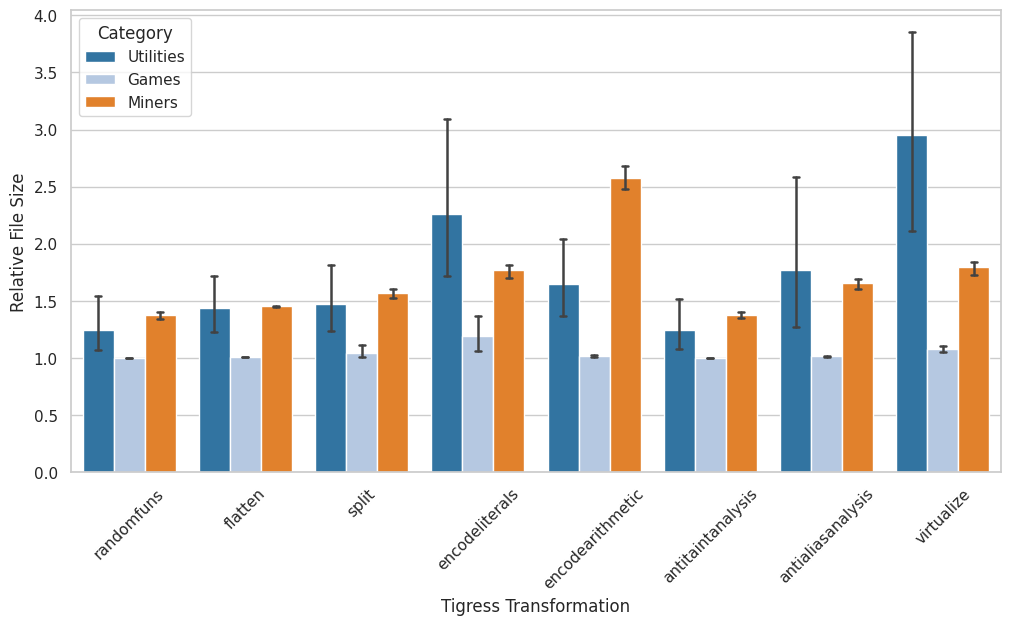

In [287]:
plot_relative_file_size_by_category(tigress_optimized, xlabel='Tigress Transformation')

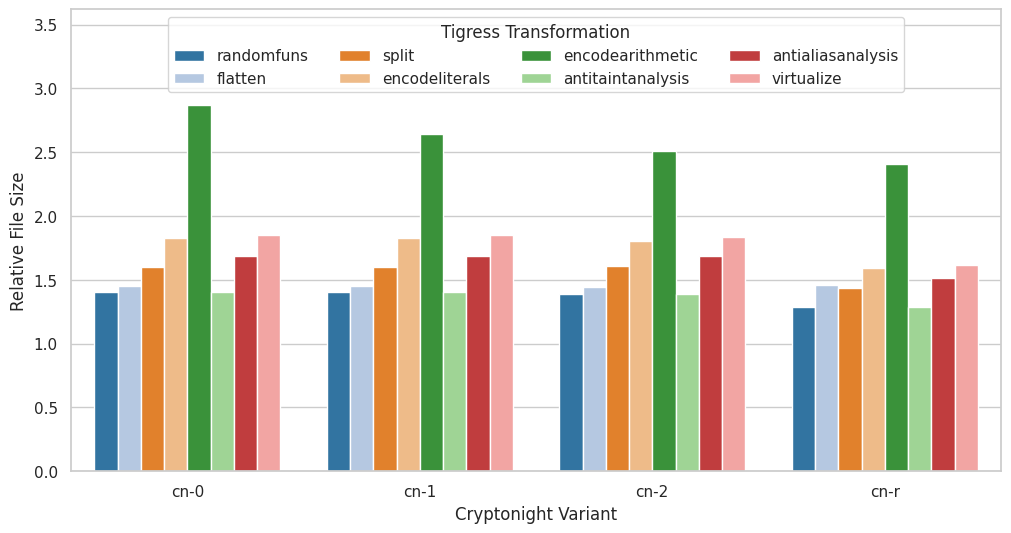

In [288]:
plot_relative_file_size_by_mining_variant(tigress_optimized, legend_title='Tigress Transformation', centered_legend=True)

### LLVM

#### Unoptimized

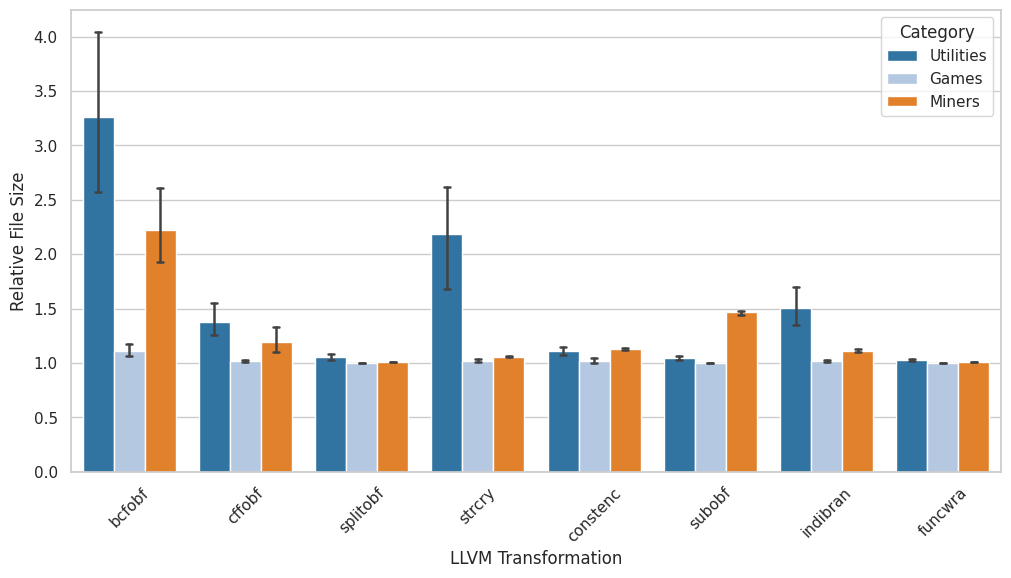

In [289]:
plot_relative_file_size_by_category(llvm_unoptimized, xlabel='LLVM Transformation')

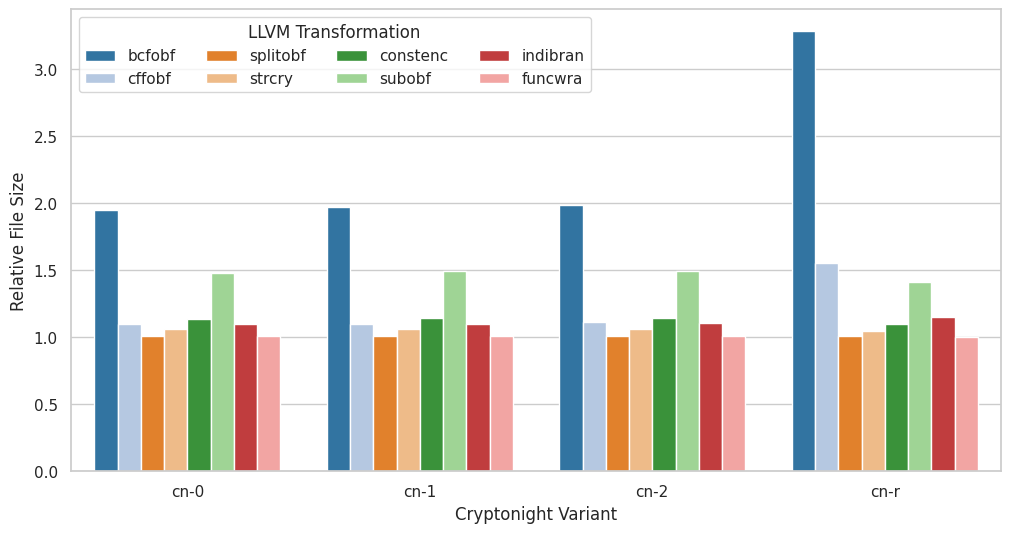

In [290]:
plot_relative_file_size_by_mining_variant(llvm_unoptimized, legend_title='LLVM Transformation')

#### Optimized

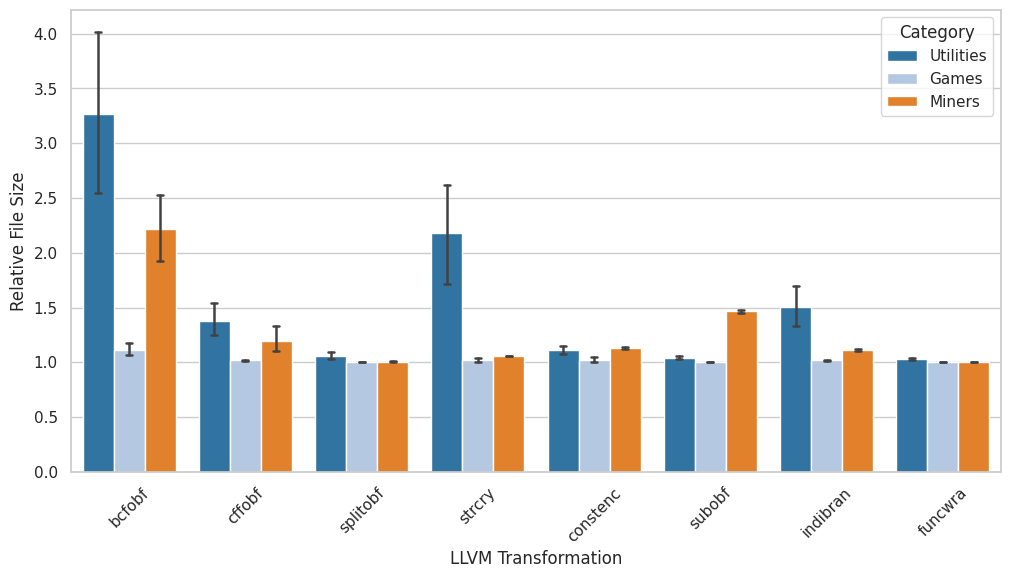

In [291]:
plot_relative_file_size_by_category(llvm_optimized, xlabel='LLVM Transformation')

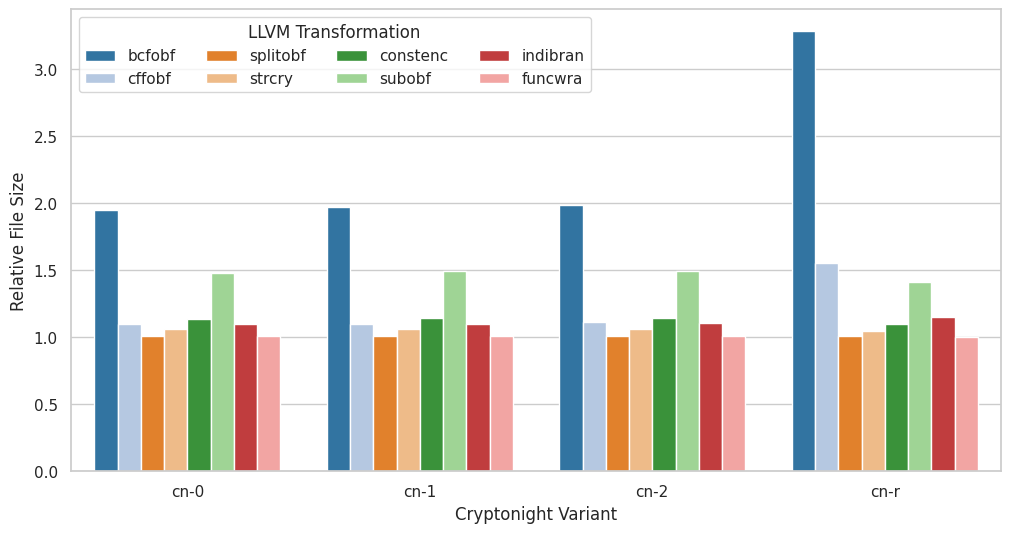

In [292]:
plot_relative_file_size_by_mining_variant(llvm_optimized, legend_title='LLVM Transformation')

### wasm-mutate

#### Unoptimized

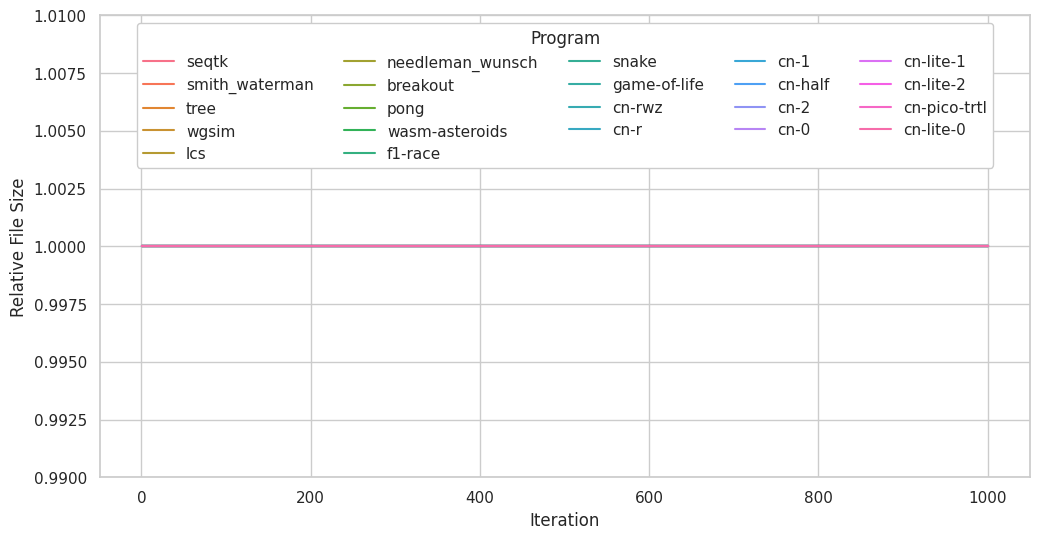

In [311]:
def plot_relative_file_size_by_iteration(df):
  plt.figure(figsize=(12, 6))
  sns.set(style="whitegrid")
  sns.lineplot(data=df, x='iteration', hue='name', y='relative_file_size')

  plt.ylabel('Relative File Size')
  plt.xlabel('Iteration')

  plt.ylim(0.99, 1.01)

  plt.legend(title='Program', loc='upper center', ncol=5, framealpha=1)

  plt.show()


plot_relative_file_size_by_iteration(wasm_mutate_unoptimized)

#### Optimized